In [30]:
import pandas as pd
from datetime import datetime
import numpy as np
import sys, os

# ---- SETUP ----
ROOT = os.path.abspath(os.getcwd())
sys.path.append(os.path.join(ROOT, "utils"))

from Prediction import predict_quantity

# Raw product IDs (from your dataset)
product_ids = [20, 120, 150, 153, 165, 298, 310, 375, 437, 448]

# Map raw → encoded (0–9)
raw_to_enc = {raw: idx for idx, raw in enumerate(product_ids)}

# Create date range for 2024
dates_2024 = pd.date_range("2024-01-01", "2024-12-31", freq="D")

rows = []
print("⏳ Generating predictions for all products for year 2024...")

for raw_pid, enc_pid in raw_to_enc.items():
    for dt in dates_2024:
        date_str = dt.strftime("%Y-%m-%d")
        try:
            pred = predict_quantity(enc_pid, date_str)
        except Exception as e:
            pred = np.nan  # if any error
        rows.append([date_str, raw_pid, pred])

df_pred = pd.DataFrame(rows, columns=["sales_date", "product_id", "predicted_quantity"])

# Save CSV
df_pred.to_csv("predictions_2024.csv", index=False)

print("\n✅ DONE! File saved as predictions_2024.csv")
print("Shape:", df_pred.shape)
df_pred.head()


⏳ Generating predictions for all products for year 2024...


c:\Users\91843\Desktop\Clouside\Inventory_forecast\utils\Prediction.py:71: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_pred = model.predict(n_periods=steps)[-1]
c:\Users\91843\Desktop\Clouside\Inventory_forecast\utils\Prediction.py:71: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_pred = model.predict(n_periods=steps)[-1]
c:\Users\91843\Desktop\Clouside\Inventory_forecast\utils\Prediction.py:71: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by positio


✅ DONE! File saved as predictions_2024.csv
Shape: (3660, 3)


,sales_date,product_id,predicted_quantity
0,2024-01-01,20,287
1,2024-01-02,20,275
2,2024-01-03,20,287
3,2024-01-04,20,278
4,2024-01-05,20,280


In [31]:
import pandas as pd

df_pred = pd.read_csv("predictions_2024.csv")

# Convert date
df_pred["sales_date"] = pd.to_datetime(df_pred["sales_date"])

# Sort by date then by product_id
df_pred = df_pred.sort_values(["sales_date", "product_id"])

df_pred.to_csv("predictions_2024_clean.csv", index=False)

print("Saved cleaned file → predictions_2024_clean.csv")
df_pred.head(10)


Saved cleaned file → predictions_2024_clean.csv


,sales_date,product_id,predicted_quantity
0,2024-01-01,20,287
366,2024-01-01,120,202
732,2024-01-01,150,285
1098,2024-01-01,153,866
1464,2024-01-01,165,214
1830,2024-01-01,298,867
2196,2024-01-01,310,230
2562,2024-01-01,375,389
2928,2024-01-01,437,248
3294,2024-01-01,448,319


In [33]:
import pandas as pd

DATA_PATH = r"top_10_sales_data.csv"

df_raw = pd.read_csv(DATA_PATH)
df_raw['sales_date'] = pd.to_datetime(df_raw['sales_date'])

print("Loaded:", df_raw.shape)
print(df_raw.head())


Loaded: (949961, 9)
  sales_date  product_id  quantity  total_price  employee_id  customer_id  \
0 2023-01-01         437         5         10.0          138        82477   
1 2023-01-01         437         3          6.0           26        46458   
2 2023-01-01         298         6         39.6            7        48576   
3 2023-01-01         120         1         16.9          236        48803   
4 2023-01-01         448         3         57.6            9        95087   

   month  year days_of_week  
0      1  2023       Sunday  
1      1  2023       Sunday  
2      1  2023       Sunday  
3      1  2023       Sunday  
4      1  2023       Sunday  


In [34]:
df_daily = df_raw.groupby(["sales_date", "product_id"])["quantity"].sum().reset_index()

df_daily = df_daily.sort_values(["product_id", "sales_date"])

print(df_daily.head())
print(df_daily.shape)


   sales_date  product_id  quantity
0  2023-01-01          20       149
10 2023-01-02          20       107
20 2023-01-03          20        63
30 2023-01-04          20        66
40 2023-01-05          20       127
(10650, 3)


In [35]:
df_actual_2024 = df_daily[
    (df_daily["sales_date"] >= "2024-01-01") &
    (df_daily["sales_date"] <= "2024-12-31")
].copy()

df_actual_2024.to_csv("actual_2024.csv", index=False)

print(df_actual_2024.head())
print(df_actual_2024.shape)


     sales_date  product_id  quantity
3650 2024-01-01          20       259
3660 2024-01-02          20       312
3670 2024-01-03          20       201
3680 2024-01-04          20       263
3690 2024-01-05          20       298
(3660, 3)


In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# Load both files
df_actual = pd.read_csv("actual_2024.csv")
df_pred = pd.read_csv("predictions_2024_clean.csv")

df_actual["sales_date"] = pd.to_datetime(df_actual["sales_date"])
df_pred["sales_date"] = pd.to_datetime(df_pred["sales_date"])

print("Actual:", df_actual.shape)
print("Pred:", df_pred.shape)


Actual: (3660, 3)
Pred: (3660, 3)


In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")   # Clean theme

def plot_product_pro(pid):
    act = df_actual[df_actual["product_id"] == pid]
    pre = df_pred[df_pred["product_id"] == pid]

    if act.empty or pre.empty:
        print(f"⚠ No data for product {pid}")
        return
    
    plt.figure(figsize=(14,6))

    # --- Smooth lines ---
    plt.plot(act["sales_date"], act["quantity"], 
             label="Actual Quantity",
             linewidth=3, alpha=0.9)

    plt.plot(pre["sales_date"], pre["quantity_predicted"], 
             label="Predicted Quantity",
             linewidth=3, linestyle="--", alpha=0.9)

    # --- Light scatter points for visibility ---
    plt.scatter(act["sales_date"], act["quantity"], s=20)
    plt.scatter(pre["sales_date"], pre["quantity_predicted"], s=20)

    # --- Title ---
    plt.title(f"📈 Actual vs Predicted — Product {pid}", fontsize=18, weight="bold")

    # --- Labels ---
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Quantity", fontsize=12)

    # --- Legend ---
    plt.legend(fontsize=12)

    # --- Better x-axis rotation ---
    plt.xticks(rotation=45)

    # --- Grid improvement ---
    plt.grid(alpha=0.3)

    # --- Remove top & right border ---
    sns.despine()

    plt.tight_layout()
    plt.show()


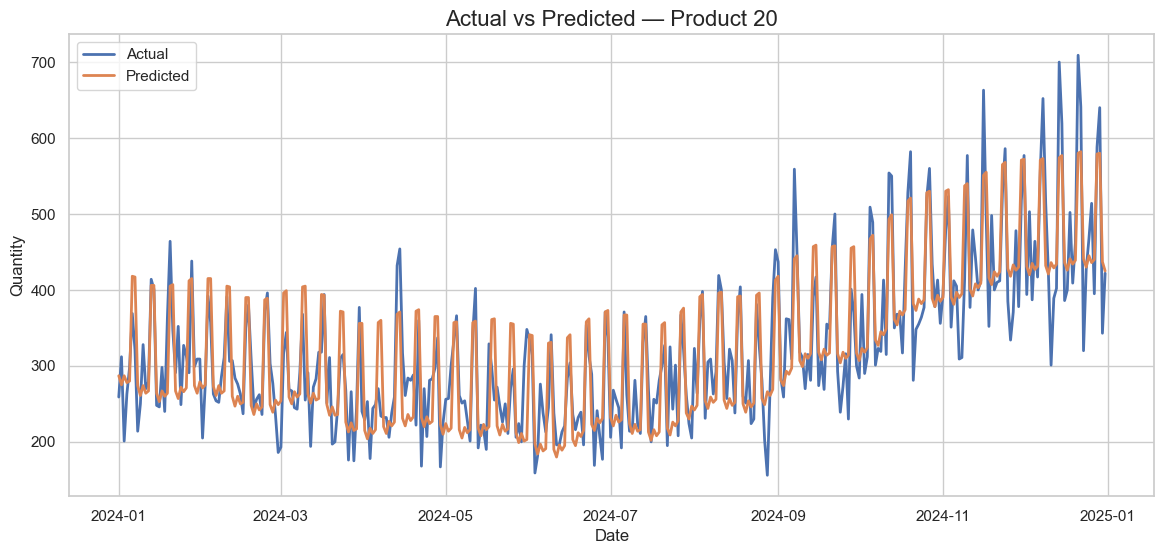

Plot completed for Product 20


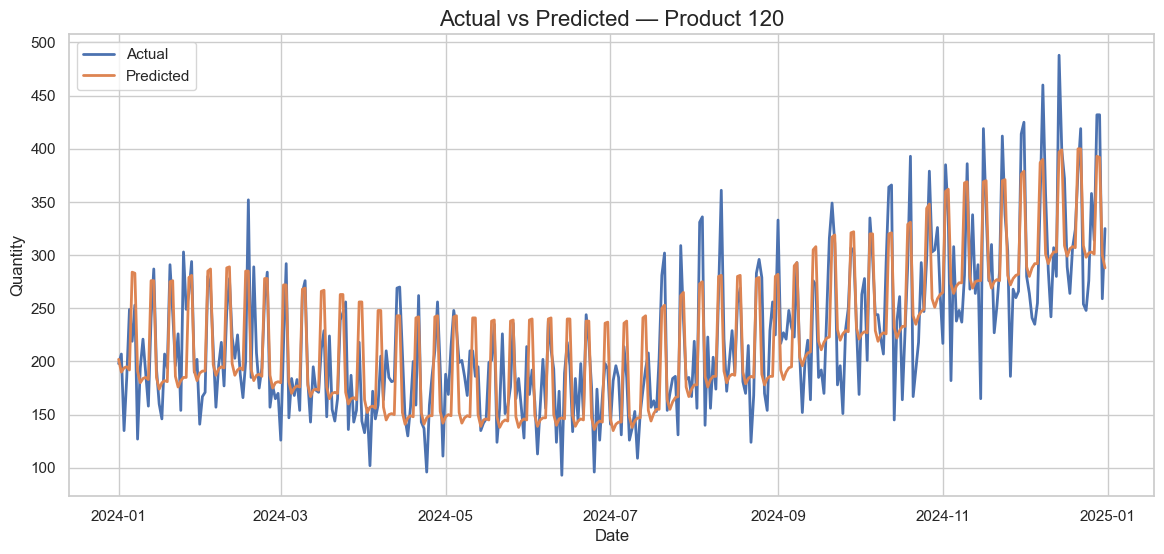

Plot completed for Product 120


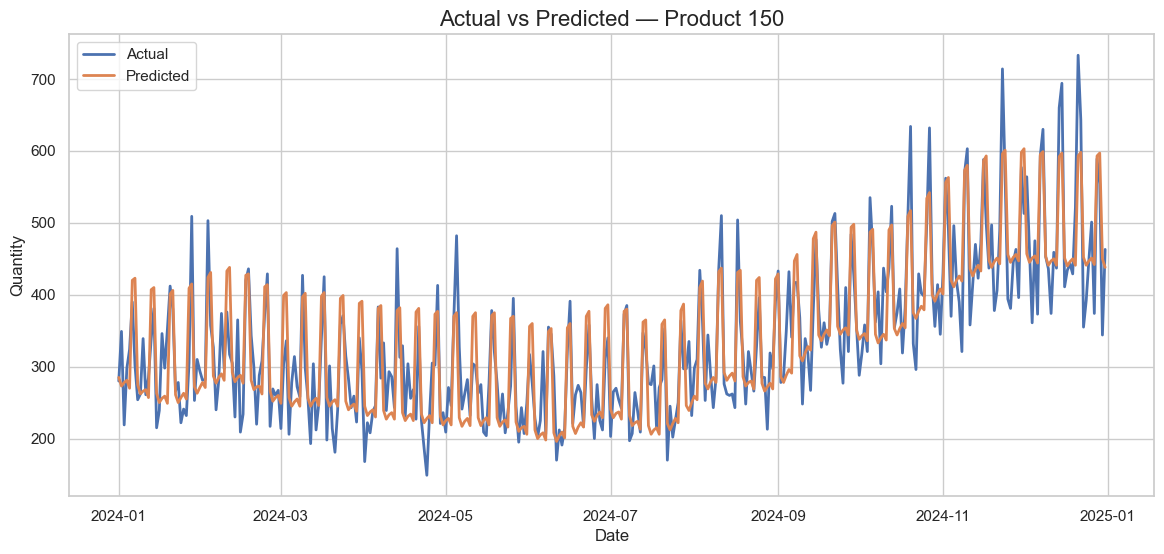

Plot completed for Product 150


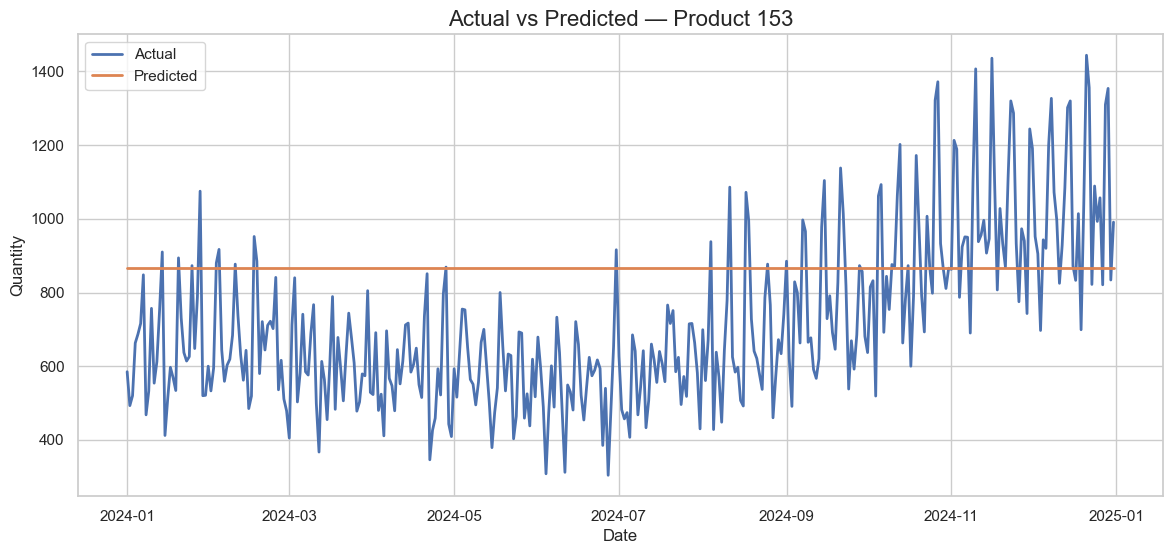

Plot completed for Product 153


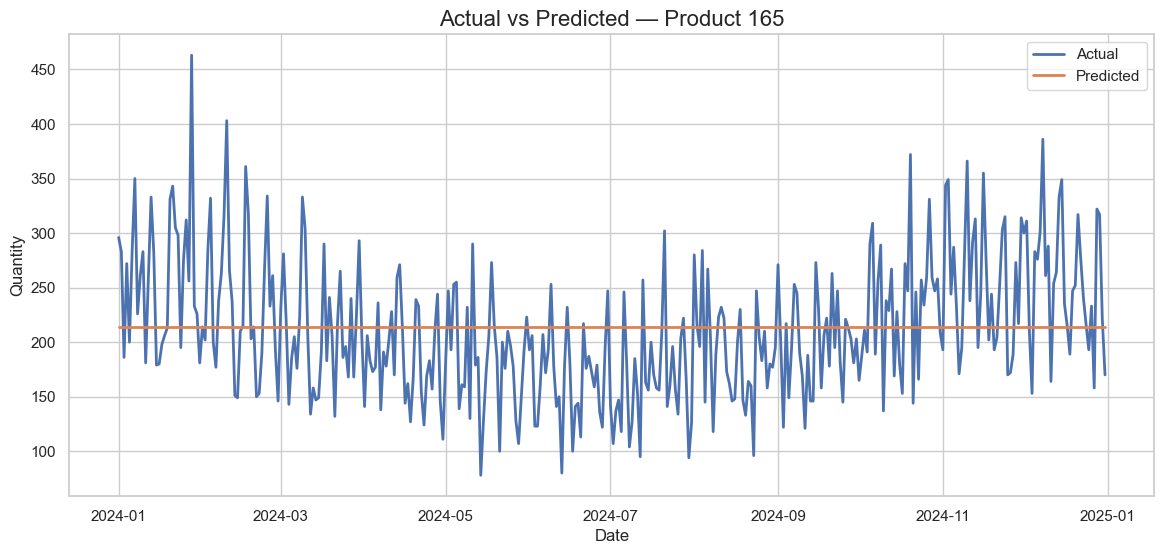

Plot completed for Product 165


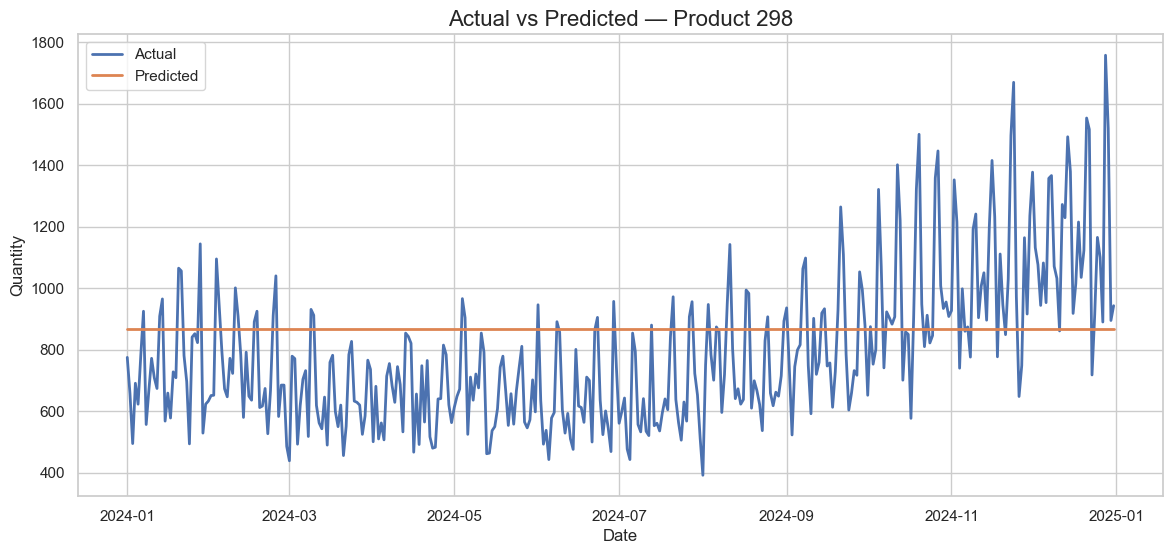

Plot completed for Product 298


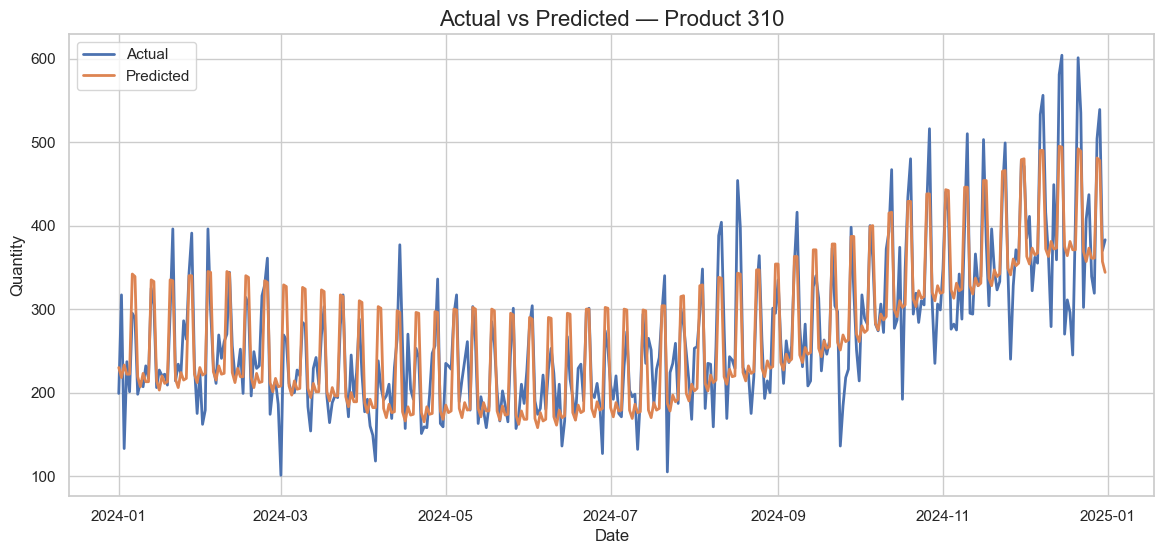

Plot completed for Product 310


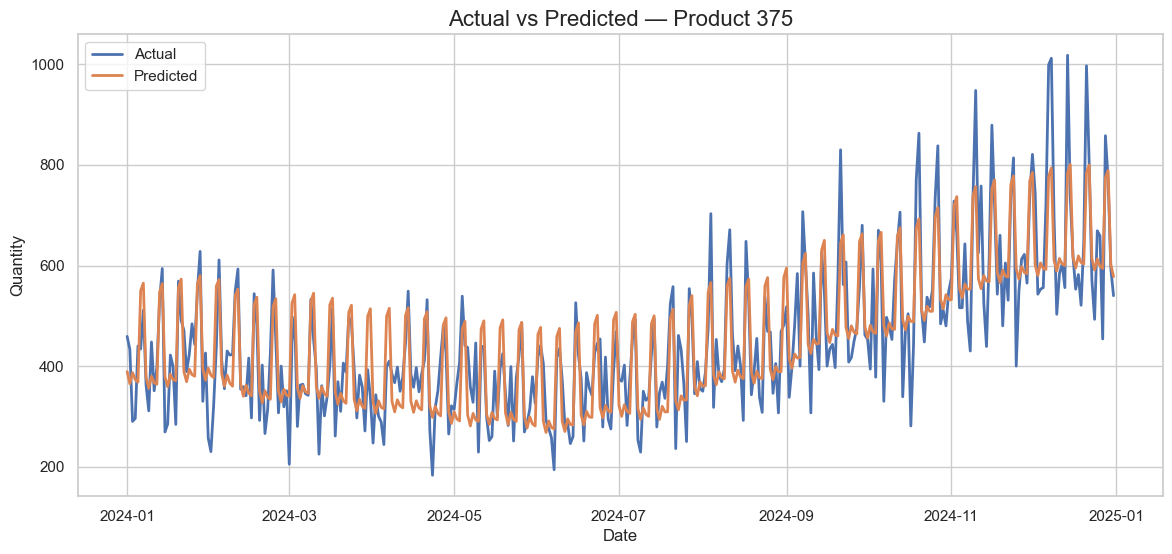

Plot completed for Product 375


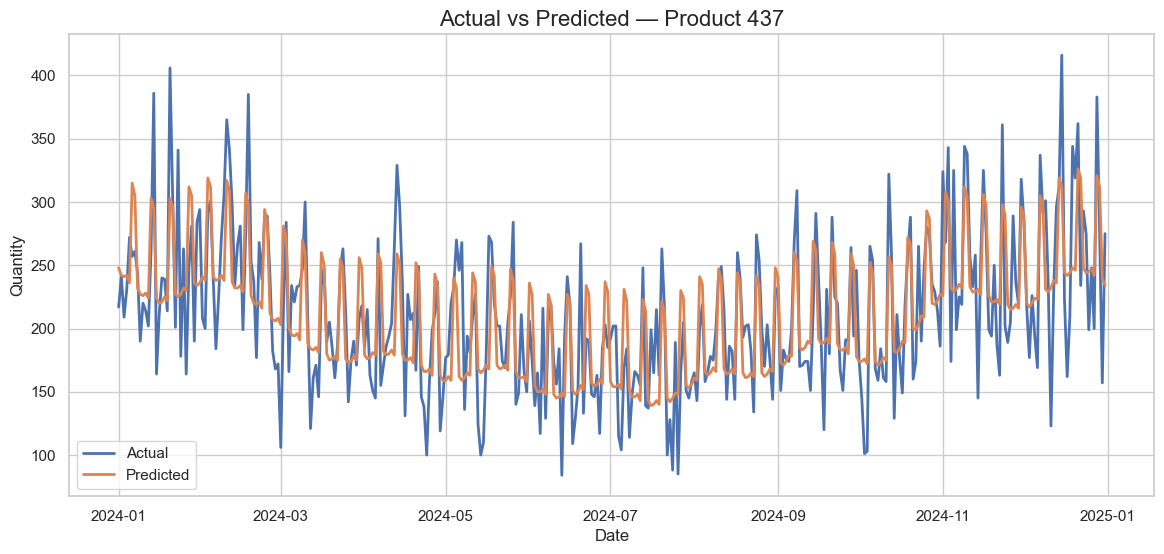

Plot completed for Product 437


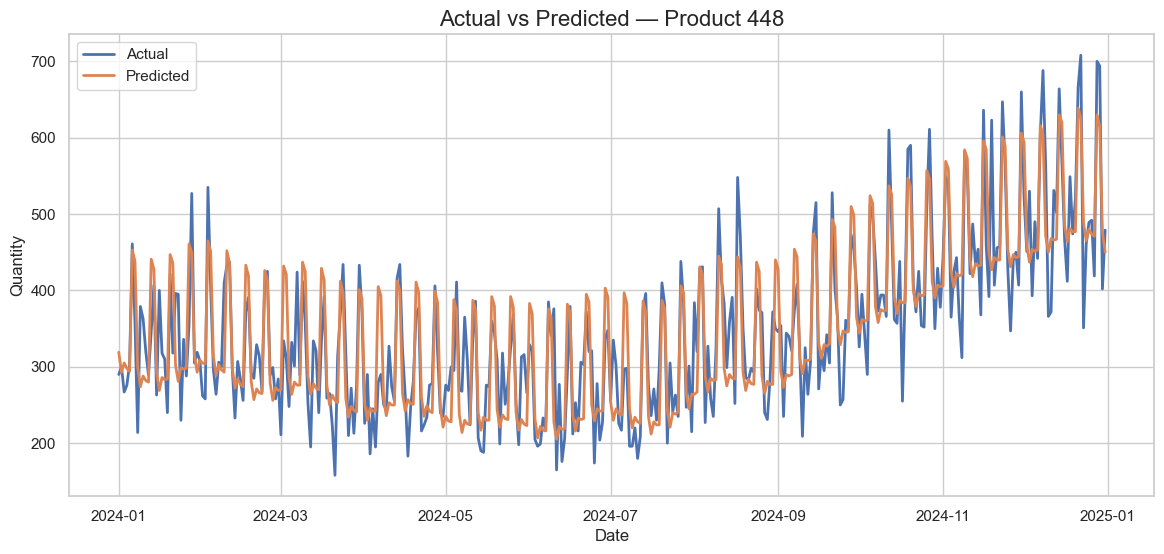

Plot completed for Product 448


In [46]:
unique_products = df_actual["product_id"].unique()

for pid in unique_products:
    plot_product(pid)
